In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
from self_supervised.layers import *
import sklearn

In [3]:
datapath = Path("../data/fgvc-aircraft/")

In [4]:
train_df = pd.read_csv(datapath/'train.csv')
valid_df = pd.read_csv(datapath/'val.csv')
test_df = pd.read_csv(datapath/'test.csv')

In [5]:
train_df.shape, test_df.shape, valid_df.shape

((3334, 3), (3333, 3), (3333, 3))

In [6]:
train_df.head()

,filename,Classes,Labels
0,1025794.jpg,707-320,0
1,1340192.jpg,707-320,0
2,0056978.jpg,707-320,0
3,0698580.jpg,707-320,0
4,0450014.jpg,707-320,0


In [7]:
(datapath/'fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images').ls().map(lambda o: o.name)

(#10000) ['0847415.jpg','1053510.jpg','0174925.jpg','1843606.jpg','1446516.jpg','0690072.jpg','1231579.jpg','1164220.jpg','2217846.jpg','0323097.jpg'...]

### Dataset

In [8]:
def read_image(filename): return PILImage.create(datapath/'fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images'/filename)
def read_image_size(filename): return PILImage.create(datapath/'fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images'/filename).shape

In [9]:
train_fns, valid_fns, test_fns = train_df['filename'].values,valid_df['filename'].values,test_df['filename'].values
filenames = np.concatenate([train_fns, valid_fns, test_fns])

In [10]:
fn2label = {**dict(zip(train_df['filename'],train_df['Classes'])),
            **dict(zip(valid_df['filename'],valid_df['Classes'])),
            **dict(zip(test_df['filename'],test_df['Classes']))} 

In [11]:
len(filenames), len(fn2label)

(10000, 10000)

In [12]:
def read_label(filename): return fn2label[filename]

In [13]:
# img_sizes = parallel(read_image_size, filenames)

In [14]:
# Counter(img_sizes)

### Modifications on ViT

In [15]:
from utils.custom_vit import *
from utils.attention import *
from utils.pooling_nms_crops import *

In [16]:
size,bs = 768,16

tfms = [[read_image, ToTensor, RandomResizedCrop(size, min_scale=.75)], 
        [read_label, Categorize()]]

valid_splitter = lambda o: True if o in test_fns else False 
dsets = Datasets(filenames, tfms=tfms, splits=FuncSplitter(valid_splitter)(filenames))

batch_augs = aug_transforms()
# batch_augs = []

stats = imagenet_stats

batch_tfms = [IntToFloatTensor] + batch_augs + [Normalize.from_stats(*stats)]
dls = dsets.dataloaders(bs=bs, after_batch=batch_tfms)

In [17]:
from torch.utils.checkpoint import checkpoint
class FullImageEncoder(Module):
    "Encoder which takes whole image input then outputs attention weights + layer features"
    def __init__(self, encoder, nblocks=11, checkpoint_nchunks=2, return_attn_wgts=True):
                
        # initialize params with warm up model
        self.patch_embed = encoder.patch_embed
        self.cls_token = encoder.cls_token
        self.pos_embed = encoder.pos_embed
        self.pos_drop = encoder.pos_drop
        
        # until layer n-1, can be changed (memory trade-off)
        self.blocks = encoder.blocks[:nblocks]        
        
        # not needed now
#         self.norm = pretrained_vit_encoder.norm
        
        # gradient checkpointing
        self.checkpoint_nchunks = checkpoint_nchunks
        
        self.return_attn_wgts = return_attn_wgts
         
    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # collect attn_wgts from all layers
        attn_wgts = []
        if self.return_attn_wgts:
            for i,blk in enumerate(self.blocks):
                if i<self.checkpoint_nchunks: x,attn_wgt = checkpoint(blk, x)
                else:                         x,attn_wgt = blk(x)
                attn_wgts.append(attn_wgt)
            return x,attn_wgts
        
        else:
            for i,blk in enumerate(self.blocks):
                if i<self.checkpoint_nchunks: x,_ = checkpoint(blk, x)
                else:                         x,_ = blk(x)
            return x
        
    def forward(self, x):
        return self.forward_features(x)

In [18]:
class MultiCropViTV2(Module):
    "Multi Size Multi Crop ViT Model"
    def __init__(self, encoder):
        
        self.full_image_encoder = FullImageEncoder(encoder, nblocks=12, checkpoint_nchunks=12)
#         self.final_block = Block(dim=768,num_heads=12,mlp_ratio=4.,qkv_bias=True,qk_scale=None)
        self.norm = partial(nn.LayerNorm, eps=1e-6)(768)
        self.classifier = create_cls_module(768*5, 120, lin_ftrs=[768], use_bn=False, first_bn=False, ps=0.)

        
    def forward(self, xb_448):
        
        # full image features and attention maps
        xb_384 = F.interpolate(xb_448, size=(384,384))
        self.full_image_encoder.return_attn_wgts = True
        x_full, attn_wgts = self.full_image_encoder(xb_384)

        # attention map bboxes
        attention_maps = generate_batch_attention_maps(attn_wgts, None, mode=None).detach()
        
        # 2 large crops - 224 / 448 (50% area)
        batch_crop_bboxes = generate_batch_crops(attention_maps.cpu().float(),
                                                 source_sz=384,
                                                 targ_sz=768,
                                                 targ_bbox_sz=384,
                                                 num_bboxes=2, 
                                                 nms_thresh=0.2)
        xb_large_crops1, xb_large_crops2 = [],[]
        for bboxes, img in zip(batch_crop_bboxes, xb_448):
            minr, minc, maxr, maxc = bboxes[0]
            crop = img[:, minr:maxr,minc:maxc]
            xb_large_crops1.append(crop)
            
            minr, minc, maxr, maxc = bboxes[1]
            crop = img[:, minr:maxr,minc:maxc]
            xb_large_crops2.append(crop)

            
        # 2 small crops - 112 / 448 (25% area)
        batch_crop_bboxes = generate_batch_crops(attention_maps.cpu().float(),
                                                 source_sz=384,
                                                 targ_sz=768,
                                                 targ_bbox_sz=192,
                                                 num_bboxes=2, 
                                                 nms_thresh=0.1)
        xb_small_crops1, xb_small_crops2 = [], []
        for bboxes, img in zip(batch_crop_bboxes, xb_448):
            minr, minc, maxr, maxc = bboxes[0]
            crop = img[:, minr:maxr,minc:maxc]
            xb_small_crops1.append(crop)
            
            minr, minc, maxr, maxc = bboxes[1]
            crop = img[:, minr:maxr,minc:maxc]
            xb_small_crops2.append(crop)
            
        
        # resize crop images
        xb_large_crops1 = F.interpolate(torch.stack(xb_large_crops1), size=(384,384))
        xb_large_crops2 = F.interpolate(torch.stack(xb_large_crops2), size=(384,384))
        xb_small_crops1 = F.interpolate(torch.stack(xb_small_crops1), size=(384,384))
        xb_small_crops2 = F.interpolate(torch.stack(xb_small_crops2), size=(384,384))
        
        # save for visualization
        i = np.random.choice(range(len(xb_448)))
        self.random_images = to_detach([xb_448[i].clone(),
                                        xb_large_crops1[i].clone().float(), 
                                        xb_large_crops2[i].clone().float(),
                                        xb_small_crops1[i].clone().float(), 
                                        xb_small_crops2[i].clone().float()
                                       ])
                
        # crop features
        self.full_image_encoder.return_attn_wgts = False
        x_large_crop1 = self.full_image_encoder(xb_large_crops1)
        x_large_crop2 = self.full_image_encoder(xb_large_crops2)
        x_small_crop1 = self.full_image_encoder(xb_small_crops1)
        x_small_crop2 = self.full_image_encoder(xb_small_crops2)
        

        x = torch.cat([self.norm(x_full)[:,0],
                       self.norm(x_large_crop1)[:,0],
                       self.norm(x_large_crop2)[:,0],
                       self.norm(x_small_crop1)[:,0],
                       self.norm(x_small_crop2)[:,0]], dim=-1)
        

        out_concat = self.classifier(x)
        return out_concat

In [19]:
class CollectImages(Callback):
    run_train,run_valid=True,False
    def __init__(self):
        self.images = []
    
    def after_pred(self):
        if self.iter % 10 == 0:
            self.images.append([TensorImage(o) for o in self.learn.model.random_images])

### Train

In [20]:
def model_splitter(m): return L(m.full_image_encoder, 
                                m.norm,
                                m.classifier).map(params)

In [21]:
# timm vit _encoder
arch = "vit_base_patch16_384"
_encoder = create_encoder(arch, pretrained=True, n_in=3)

# custom vit encoder with timm weights
encoder = VisionTransformer(img_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12)
encoder.head = Identity()
encoder.load_state_dict(_encoder.state_dict());

In [22]:
metrics = accuracy
loss_func = LabelSmoothingCrossEntropyFlat(0.1)

In [23]:
mcvit_model = MultiCropViTV2(encoder)

In [24]:
cbs = [CollectImages()]
learn = Learner(dls, mcvit_model, opt_func=ranger, cbs=cbs, metrics=metrics, loss_func=loss_func, splitter=model_splitter)
learn.to_fp16();

In [25]:
epochs = 5
lr = 3e-3

In [ ]:
learn.freeze_to(1)
learn.fit_one_cycle(epochs, lr_max=(lr), pct_start=0.5)

epoch,train_loss,valid_loss,accuracy,time
0,3.400933,3.240463,0.233123,06:08
1,2.986856,2.983089,0.289229,06:09
2,2.502708,2.597802,0.426043,06:09


/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [ ]:
lr /= 3 
learn.unfreeze()
learn.fit_one_cycle(int(epochs**2), lr_max=[lr,lr,lr], pct_start=0.5)

In [30]:
learn.recorder.values

[(#3) [1.5412099361419678,1.9320892095565796,0.6552655100822449],
 (#3) [1.5018556118011475,1.9084948301315308,0.6666666865348816],
 (#3) [1.45945405960083,1.787274956703186,0.7050704956054688],
 (#3) [1.4104739427566528,1.6640408039093018,0.7560756206512451],
 (#3) [1.388414978981018,1.6792198419570923,0.7416741847991943],
 (#3) [1.4345604181289673,1.7883765697479248,0.69456946849823],
 (#3) [1.4441641569137573,1.819337010383606,0.6948694586753845],
 (#3) [1.5147756338119507,1.7468080520629883,0.7011701464653015],
 (#3) [1.4936355352401733,1.7198294401168823,0.7230722904205322],
 (#3) [1.5148820877075195,1.819583773612976,0.6933693289756775],
 (#3) [1.566612720489502,1.5934743881225586,0.7554755210876465],
 (#3) [1.509394884109497,1.7053544521331787,0.735973596572876],
 (#3) [1.439611792564392,1.8251010179519653,0.7026702761650085],
 (#3) [1.4424389600753784,1.633908748626709,0.7464746236801147],
 (#3) [1.3084558248519897,1.7999098300933838,0.6915691494941711],
 (#3) [1.19866275787353

In [31]:
len(learn.collect_images.images)

1260

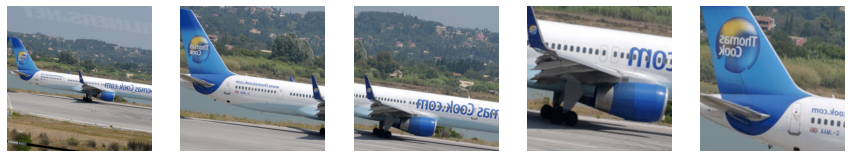

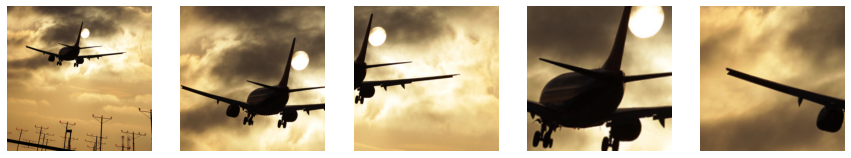

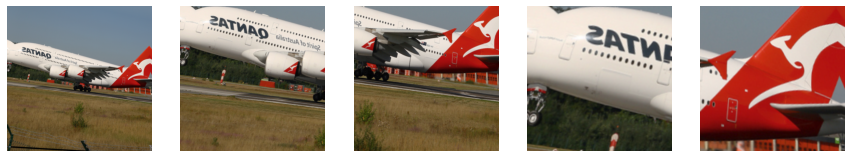

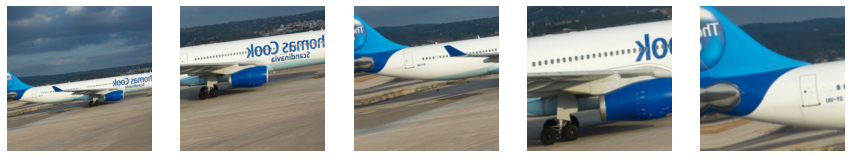

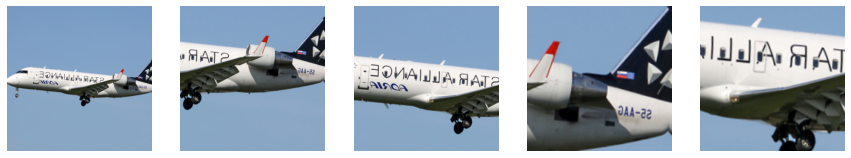

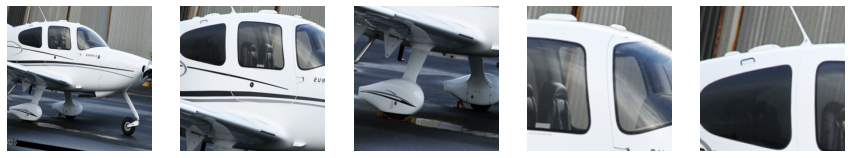

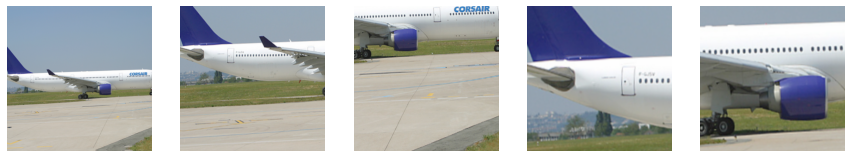

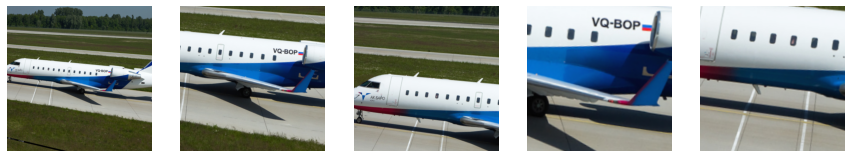

In [33]:
for images in learn.collect_images.images[-8:]:
    show_images([dls.after_batch.decode(o[None,...])[0] for o in images])